# DeepLearning

### Introduction
In this notebook, we introduce H2O Deep Learning via fully-connected artificial neural networks. We also show many useful features of H2O such as hyper-parameter optimization, Flow, and checkpointing. There are other notebooks that use more complex convolutional neural networks ranging from LeNet all the way to Inception Resnet V2.

### MNIST Dataset
The MNIST database is a well-known academic dataset used to benchmark
classification performance. The data consists of 60,000 training images and
10,000 test images. Each image is a standardized $28^2$ pixel greyscale image of
a single handwritten digit. A sample of the scanned handwritten digits is
shown
![Example MNIST digit images](images/mnist.png)

In [1]:
import h2o
h2o.init(nthreads=-1)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 min 33 secs
H2O cluster version:,3.11.0.99999
H2O cluster version age:,1 hour and 55 minutes
H2O cluster name:,arno
H2O cluster total nodes:,1
H2O cluster free memory:,13.96 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [2]:
import os.path
PATH = os.path.expanduser("~/h2o-3/")

In [3]:
test_df = h2o.import_file(PATH + "bigdata/laptop/mnist/test.csv.gz")

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [4]:
train_df = h2o.import_file(PATH + "bigdata/laptop/mnist/train.csv.gz")

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


Specify the response and predictor columns

In [5]:
y = "C785"
x = train_df.names[0:784]

In [6]:
train_df[y] = train_df[y].asfactor()
test_df[y] = test_df[y].asfactor()

Train Deep Learning model and validate on test set

In [7]:
from h2o.estimators.deepwater import H2ODeepWaterEstimator

In [8]:
model = H2ODeepWaterEstimator(
   distribution="multinomial",
   activation="rectifier",
   mini_batch_size=128,
   hidden=[1024,1024],
   hidden_dropout_ratios=[0.5,0.5],      ## for better generalization
   input_dropout_ratio=0.1,
   sparse=True,                          ## can result in speedup for sparse data
   epochs=10)                            ## need more epochs for a better model

In [9]:
model.train(
    x=x, 
    y=y,
    training_frame=train_df,
    validation_frame=test_df
)

deepwater Model Build progress: |█████████████████████████████████████████████████████████████| 100%


In [10]:
model.scoring_history()

,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
0,,2016-10-23 01:30:37,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2016-10-23 01:30:38,3.250 sec,6585 obs/sec,0.068267,1,4096.0,0.447394,6.906614,0.200161,0.438178,6.624686,0.1920
2,,2016-10-23 01:30:52,16.392 sec,25255 obs/sec,5.529600,81,331776.0,0.118547,0.479450,0.014053,0.205451,1.455522,0.0422
3,,2016-10-23 01:30:58,22.772 sec,26887 obs/sec,8.465067,124,507904.0,0.079524,0.218424,0.006324,0.196975,1.336098,0.0388
4,,2016-10-23 01:31:02,26.488 sec,27373 obs/sec,10.035200,147,602112.0,0.062569,0.135215,0.003915,0.197231,1.342081,0.0389
5,,2016-10-23 01:31:02,27.130 sec,27330 obs/sec,10.035200,147,602112.0,0.079524,0.218424,0.006324,0.196975,1.336098,0.0388


In [11]:
model.model_performance(train=True) # training metrics


ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 0.00632403131935
RMSE: 0.0795237783267
LogLoss: 0.218424309446
Mean Per-Class Error: 0.00637963860238
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
960.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0020790,2 / 962
0.0,1115.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"0 / 1,115"
0.0,0.0,1016.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0029441,"3 / 1,019"
0.0,3.0,0.0,976.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0081301,8 / 984
0.0,1.0,0.0,0.0,1017.0,0.0,0.0,0.0,1.0,1.0,0.0029412,"3 / 1,020"
0.0,0.0,1.0,3.0,0.0,912.0,1.0,0.0,6.0,1.0,0.0129870,12 / 924
0.0,0.0,0.0,0.0,1.0,0.0,923.0,0.0,0.0,0.0,0.0010823,1 / 924
0.0,1.0,1.0,0.0,0.0,0.0,0.0,1043.0,0.0,0.0,0.0019139,"2 / 1,045"
0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,943.0,1.0,0.0052743,5 / 948
0.0,1.0,0.0,0.0,4.0,0.0,0.0,21.0,1.0,994.0,0.0264447,"27 / 1,021"


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9936759
2,0.9938767
3,0.9938767
4,0.9938767
5,0.9938767
6,0.9938767
7,0.9938767
8,0.9938767
9,0.9938767
10,0.9999999


In [12]:
model.model_performance(valid=True) # validation metrics


ModelMetricsMultinomial: deepwater
** Reported on validation data. **

MSE: 0.0387991228965
RMSE: 0.196974929614
LogLoss: 1.33609811491
Mean Per-Class Error: 0.0394969339854
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
959.0,1.0,2.0,0.0,2.0,4.0,6.0,3.0,2.0,1.0,0.0214286,21 / 980
0.0,1122.0,3.0,0.0,0.0,0.0,3.0,4.0,3.0,0.0,0.0114537,"13 / 1,135"
3.0,2.0,989.0,2.0,6.0,1.0,5.0,10.0,11.0,3.0,0.0416667,"43 / 1,032"
0.0,1.0,7.0,969.0,1.0,4.0,1.0,10.0,10.0,7.0,0.0405941,"41 / 1,010"
2.0,1.0,4.0,1.0,949.0,0.0,4.0,7.0,3.0,11.0,0.0336049,33 / 982
4.0,1.0,1.0,20.0,5.0,824.0,13.0,7.0,14.0,3.0,0.0762332,68 / 892
5.0,2.0,2.0,0.0,8.0,6.0,929.0,1.0,4.0,1.0,0.0302714,29 / 958
1.0,6.0,7.0,2.0,1.0,1.0,1.0,1001.0,3.0,5.0,0.0262646,"27 / 1,028"
1.0,0.0,6.0,7.0,3.0,5.0,3.0,8.0,933.0,8.0,0.0420945,41 / 974
4.0,5.0,2.0,4.0,11.0,5.0,1.0,34.0,6.0,937.0,0.0713578,"72 / 1,009"


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9612
2,0.9651
3,0.9651
4,0.9651
5,0.9651
6,0.9651
7,0.9651
8,0.9651
9,0.9651
10,1.0


### Inspect the model in Flow
It is highly recommended to use [Flow](http://localhost:54321/) to visualize the model training process and to inspect the model before using it for further steps.

## Using Crossvalidation

If the value specified for nfolds is a positive integer, N-fold cross-validation is
performed on the training frame and the cross-validation metrics are computed
and stored as model output. 

To disable cross-validation, use `nfolds=0`, which is the default value.

Advanced users can also specify a fold column that defines the holdout
fold associated with each row. By default, the holdout fold assignment is
random. H2O supports other schemes such as round-robin assignment using the modulo
operator.

Perform 3-fold cross-validation on training_frame

In [13]:
model_crossvalidated = H2ODeepWaterEstimator(
   distribution="multinomial",
   activation="rectifier",
   mini_batch_size=128,
   hidden=[1024,1024],
   hidden_dropout_ratios=[0.5,0.5],
   input_dropout_ratio=0.1,
   sparse=True,
   epochs=10,
   nfolds=3
)

In [14]:
model_crossvalidated.train(
    x=x,
    y=y,
    training_frame=train_df
)

deepwater Model Build progress: |█████████████████████████████████████████████████████████████| 100%


## Extracting and Handling the Results

We can now extract the parameters of our model, examine the scoring process,
and make predictions on new data.

In [15]:
# View specified parameters of the Deep Learning model
model_crossvalidated.params;

In [16]:
# Examine the trained model
model_crossvalidated

Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1477211337936_2
Status of Deep Learning Model: MLP: [1024, 1024], 6.9 MB, predicting C785, 10-class classification, 606,208 training samples, mini-batch size 128



,input_neurons,rate,momentum
,717,0.0031129,0.99




ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 0.00457317073525
RMSE: 0.0676252226262
LogLoss: 0.156785286247
Mean Per-Class Error: 0.00458892837481
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
984.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0030395,3 / 987
0.0,1090.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"0 / 1,090"
0.0,0.0,925.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0085745,8 / 933
0.0,1.0,0.0,1032.0,0.0,5.0,0.0,1.0,2.0,0.0,0.0086455,"9 / 1,041"
0.0,0.0,0.0,0.0,955.0,1.0,0.0,0.0,0.0,3.0,0.0041710,4 / 959
0.0,0.0,0.0,0.0,0.0,899.0,0.0,0.0,1.0,0.0,0.0011111,1 / 900
0.0,0.0,0.0,0.0,0.0,6.0,982.0,0.0,3.0,0.0,0.0090817,9 / 991
0.0,1.0,0.0,2.0,0.0,0.0,0.0,1014.0,0.0,0.0,0.0029499,"3 / 1,017"
0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,957.0,1.0,0.0020855,2 / 959
0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,957.0,0.0062305,6 / 963


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9954268
2,0.9962398
3,0.9962398
4,0.9962398
5,0.9962398
6,0.9962398
7,0.9962398
8,0.9962398
9,0.9962398
10,1.0



ModelMetricsMultinomial: deepwater
** Reported on cross-validation data. **

MSE: 0.0469650888528
RMSE: 0.216714302372
LogLoss: 1.61860098993
Mean Per-Class Error: 0.0473418169932
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
5781.0,2.0,16.0,9.0,8.0,24.0,45.0,13.0,17.0,8.0,0.0239743,"142 / 5,923"
1.0,6621.0,40.0,14.0,14.0,5.0,5.0,14.0,24.0,4.0,0.0179472,"121 / 6,742"
27.0,33.0,5642.0,55.0,32.0,14.0,33.0,40.0,64.0,18.0,0.0530379,"316 / 5,958"
15.0,19.0,81.0,5728.0,9.0,120.0,11.0,35.0,74.0,39.0,0.0657315,"403 / 6,131"
14.0,26.0,31.0,6.0,5535.0,14.0,40.0,35.0,23.0,118.0,0.0525505,"307 / 5,842"
35.0,17.0,11.0,62.0,9.0,5153.0,56.0,13.0,41.0,24.0,0.0494374,"268 / 5,421"
39.0,12.0,18.0,2.0,13.0,49.0,5759.0,2.0,23.0,1.0,0.0268672,"159 / 5,918"
14.0,31.0,47.0,18.0,35.0,15.0,3.0,5978.0,18.0,106.0,0.0458101,"287 / 6,265"
26.0,51.0,47.0,72.0,13.0,102.0,33.0,11.0,5473.0,23.0,0.0646043,"378 / 5,851"
18.0,19.0,18.0,46.0,99.0,49.0,4.0,121.0,63.0,5512.0,0.0734577,"437 / 5,949"


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9530333
2,0.9582833
3,0.9582833
4,0.9582833
5,0.9582833
6,0.9582833
7,0.9582833
8,0.9582833
9,0.9582833
10,1.0


Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
accuracy,0.9530309,0.0009008,0.9530976,0.9545568,0.9514383
err,0.0469691,0.0009008,0.0469023,0.0454432,0.0485617
err_count,939.3333,16.756426,938.0,911.0,969.0
logloss,1.618684,0.0309317,1.6179992,1.5654545,1.6725984
max_per_class_error,0.0808848,0.0001057,0.0810950,0.0807613,0.0807980
mean_per_class_accuracy,0.9526111,0.0009549,0.9526068,0.9542671,0.9509594
mean_per_class_error,0.0473889,0.0009549,0.0473932,0.0457329,0.0490406
mse,0.0469675,0.0009030,0.0469038,0.0454363,0.0485624
r2,0.9943744,0.0000785,0.9944134,0.9944866,0.9942232
rmse,0.2166999,0.0020825,0.2165729,0.2131580,0.2203688


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
,2016-10-23 01:32:02,0.000 sec,None,0.0,0,0.0,nan,nan,nan
,2016-10-23 01:32:03,59.557 sec,15226 obs/sec,0.0682667,1,4096.0,0.4237232,6.1895757,0.1795732
,2016-10-23 01:32:08,1 min 4.816 sec,21045 obs/sec,1.8432,27,110592.0,0.2492259,2.1396820,0.0620935
,2016-10-23 01:32:13,1 min 9.947 sec,24762 obs/sec,4.1642667,61,249856.0,0.1509366,0.7850167,0.0227642
,2016-10-23 01:32:18,1 min 14.976 sec,27588 obs/sec,6.8266667,100,409600.0,0.0977387,0.3299436,0.0095528
,2016-10-23 01:32:23,1 min 20.077 sec,28755 obs/sec,9.4208,138,565248.0,0.0882894,0.2668199,0.0078252
,2016-10-23 01:32:25,1 min 21.663 sec,28923 obs/sec,10.1034667,148,606208.0,0.0676252,0.1567853,0.0045732


Note: The validation error is based on the
parameter `score_validation_samples`, which can be used to sample the validation set (by default, the entire validation set is used).

In [17]:
## Validation error of the original model (using a train/valid split)
model.mean_per_class_error(valid=True)

0.03949693398541933

In [18]:
## Training error of the model trained on 100% of the data
model_crossvalidated.mean_per_class_error(train=True)

0.004588928374813425

In [19]:
## Estimated generalization error of the cross-validated model
model_crossvalidated.mean_per_class_error(xval=True)

0.04734181699323046

Clearly, the model parameters aren't tuned perfectly yet, as 4-5% test set error is rather large.

In [20]:
#ls ../../h2o-docs/src/booklets/v2_2015/source/images/

## Predicting

Once we have a satisfactory model (as determined by the validation or crossvalidation
metrics), use the `h2o.predict()` command to compute and store
predictions on new data for additional refinements in the interactive data science
process.

In [21]:
predictions = model_crossvalidated.predict(test_df)

deepwater prediction progress: |██████████████████████████████████████████████████████████████| 100%


In [22]:
predictions.describe()

Rows:10000
Cols:11




,predict,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9
type,enum,int,real,int,real,real,real,real,int,real,real
mins,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,0.0975,0.1154,0.1009,0.101013506511,0.0945999996543,0.0943864928449,0.0944999999885,0.1015,0.099400000654,0.100800000349
maxs,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sigma,NaN,0.296652237907,0.319520029583,0.30121132586,0.301342276063,0.292676280751,0.292360290599,0.292537703227,0.302004752756,0.299213289694,0.301078768385
zeros,975,9025,8845,8991,8984,9053,9053,9053,8985,9004,8987
missing,0,0,0,0,0,0,0,0,0,0,0
0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Variable Importance

Variable importance allows us to view the absolute and relative predictive strength of
each feature in the prediction task.
Each H2O algorithm class has its own methodology for computing variable importance.

You can enable the variable importance, by setting the `variable_importances` parameter to `True`.

H2O’s Deep Learning uses the Gedeon method [Gedeon, 1997](http://users.cecs.anu.edu.au/~Tom.Gedeon/pdfs/ContribDataMinv2.pdf), which is disabled
by default since it can be slow for large networks. 

If variable importance is a top priority in your analysis, consider training a Distributed Random Forest (DRF) model and compare the generated variable importances.

In [23]:
# Train Deep Learning model and validate on test set and save the variable importances
from h2o.estimators.deeplearning import H2ODeepLearningEstimator  ## H2ODeepWaterEstimator doesn't yet have variable importances

model_variable_importances = H2ODeepLearningEstimator(
     distribution="multinomial",
     activation="RectifierWithDropout",  ## shortcut for hidden_dropout_ratios=[0.5,0.5,0.5]
     hidden=[32,32,32],         ## smaller number of neurons to be fast enough on the CPU
     input_dropout_ratio=0.1,
     sparse=True,
     epochs=1,                  ## not interested in a good model here
     variable_importances=True) ## this is not yet implemented for DeepWaterEstimator

In [24]:
model_variable_importances.train(
         x=x,
         y=y,
         training_frame=train_df,
         validation_frame=test_df)

deeplearning Model Build progress: |██████████████████████████████████████████████████████████| 100%


In [25]:
# Retrieve the variable importance
import pandas as pd
pd.DataFrame(model_variable_importances.varimp())

,0,1,2,3
0,C348,1.000000,1.000000,0.002358
1,C376,0.998998,0.998998,0.002355
2,C349,0.931029,0.931029,0.002195
3,C377,0.920840,0.920840,0.002171
4,C403,0.918617,0.918617,0.002166
5,C435,0.896482,0.896482,0.002113
6,C434,0.893335,0.893335,0.002106
7,C296,0.881438,0.881438,0.002078
8,C570,0.878090,0.878090,0.002070
9,C380,0.877960,0.877960,0.002070


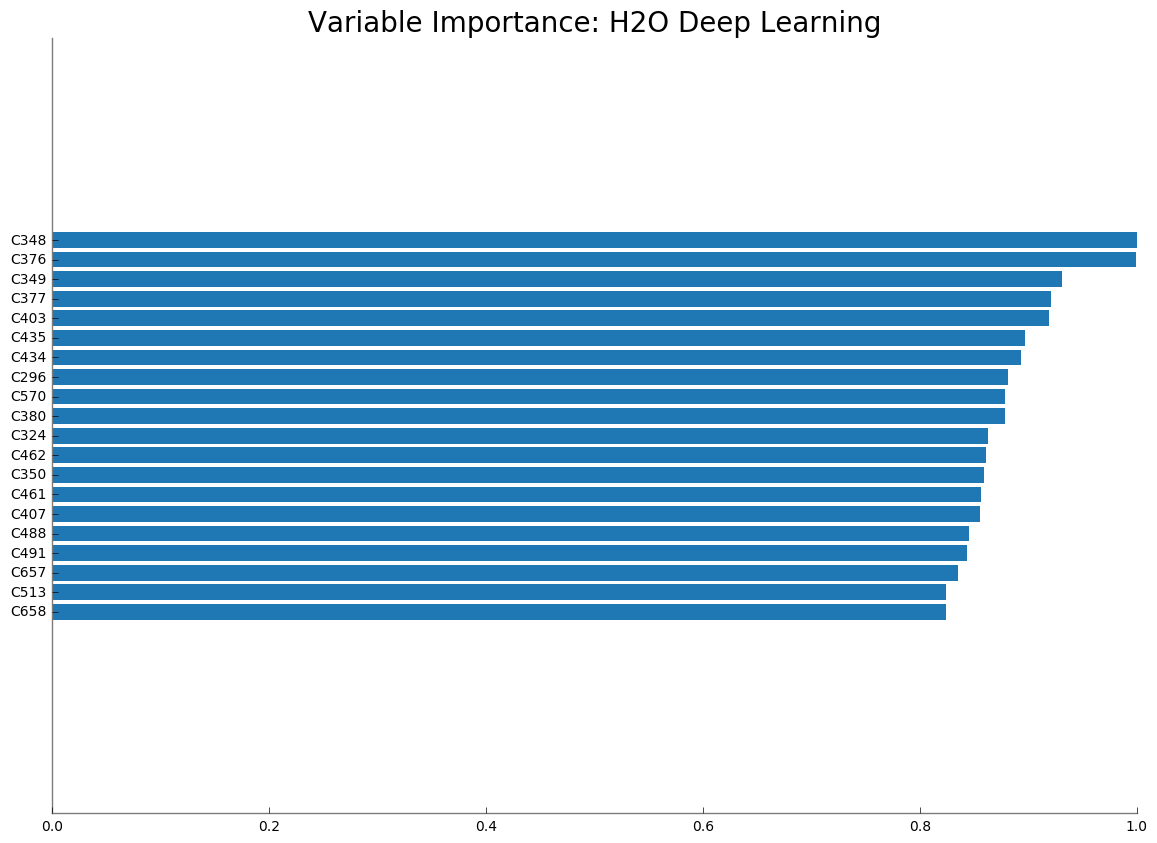

In [26]:
model_variable_importances.varimp_plot(num_of_features=20)

## Model Comparison with Grid Search

Grid search provides more subtle insights into the model tuning and selection
process by inspecting and comparing our trained models after the grid search process is complete. 

To learn when and how to select different parameter
configurations in a grid search, refer to Parameters for parameter descriptions
and configurable values.

There are different strategies to explore the hyperparameter combinatorial space:

- Cartesian Search: test *every* single combination
- Random Search: sample combinations

## Cartesian Search
In this example, two different network topologies and two different learning rates are specified. This grid search model trains all 4 different models (all possible combinations of these parameters); other parameter combinations can
be specified for a larger space of models. Note that the models will most likely
converge before the default value of epochs, since early stopping is enabled.

In [27]:
from h2o.grid.grid_search import H2OGridSearch

In [28]:
hyper_parameters = {
    "hidden":[[200,200,200],[300,300]], 
    "learning_rate":[1e-3,5e-3],
}

model_grid = H2OGridSearch(H2ODeepWaterEstimator, hyper_params=hyper_parameters)

In [29]:
model_grid.train(
    x=x, 
    y=y,
    distribution="multinomial", 
    epochs=50,   ## might stop earlier since we enable early stopping below
    training_frame=train_df, 
    validation_frame=test_df,
    score_interval=2,                ## score no more than every 2 seconds
    score_duty_cycle=0.5,            ## score up to 50% of the time - to enable early stopping
    score_training_samples=1000,     ## use a subset of the training frame for faster scoring
    score_validation_samples=1000,   ## use a subset of the validation frame for faster scoring
    stopping_rounds=3,
    stopping_tolerance=0.05,
    stopping_metric="misclassification",
    sparse = True,
    mini_batch_size=256
)

deepwater Grid Build progress: |██████████████████████████████████████████████████████████████| 100%


In [30]:
# print model grid search results
model_grid

              hidden learning_rate  \
0         [300, 300]         0.005   
1    [200, 200, 200]         0.005   
2    [200, 200, 200]         0.001   
3         [300, 300]         0.001   

                                                           model_ids  \
0  Grid_DeepWater_py_2_sid_9b8f_model_python_1477211337936_4_model_3   
1  Grid_DeepWater_py_2_sid_9b8f_model_python_1477211337936_4_model_2   
2  Grid_DeepWater_py_2_sid_9b8f_model_python_1477211337936_4_model_0   
3  Grid_DeepWater_py_2_sid_9b8f_model_python_1477211337936_4_model_1   

              logloss  
0  1.7487250978191204  
1   3.379028978326725  
2  3.4048331134204655  
3  3.8290355168863095  


In [31]:
for gmodel in model_grid:
    print gmodel.model_id + " mean per class error: " + str(gmodel.mean_per_class_error())

Grid_DeepWater_py_2_sid_9b8f_model_python_1477211337936_4_model_3 mean per class error: 0.023297786771
Grid_DeepWater_py_2_sid_9b8f_model_python_1477211337936_4_model_2 mean per class error: 0.0541836154055
Grid_DeepWater_py_2_sid_9b8f_model_python_1477211337936_4_model_0 mean per class error: 0.0828773953361
Grid_DeepWater_py_2_sid_9b8f_model_python_1477211337936_4_model_1 mean per class error: 0.0851016690147


In [32]:
import pandas as pd

In [33]:
grid_results = pd.DataFrame([[m.model_id, m.mean_per_class_error(valid=True)] for m in model_grid])
grid_results

,0,1
0,Grid_DeepWater_py_2_sid_9b8f_model_python_1477211337936_4_model_3,0.052769
1,Grid_DeepWater_py_2_sid_9b8f_model_python_1477211337936_4_model_2,0.099326
2,Grid_DeepWater_py_2_sid_9b8f_model_python_1477211337936_4_model_0,0.096929
3,Grid_DeepWater_py_2_sid_9b8f_model_python_1477211337936_4_model_1,0.112104


## Random Grid Search

If the search space is too large you can let the GridSearch algorithm select the parameter, by sampling from the parameter space. 

Just specify how many models (and/or how much training time) you want, and provide a seed to make the random selection deterministic.

In [34]:
hyper_parameters = {
    "hidden":[[1000,1000],[2000]],
    "learning_rate":[s*1e-3 for s in range(30,100)],
    "momentum_start":[s*1e-3 for s in range(0,900)],
    "momentum_stable":[s*1e-3 for s in range(900,1000)],
}

In [35]:
search_criteria = {"strategy":"RandomDiscrete", "max_models":10, "max_runtime_secs":100, "seed":123456}

model_grid_random_search = H2OGridSearch(H2ODeepWaterEstimator,
    hyper_params=hyper_parameters,
    search_criteria=search_criteria)

In [36]:
model_grid_random_search.train(
    x=x, y=y,
    distribution="multinomial", 
    epochs=50,   ## might stop earlier since we enable early stopping below
    training_frame=train_df, 
    validation_frame=test_df,
    score_interval=2,                ## score no more than every 2 seconds
    score_duty_cycle=0.5,            ## score up to 50% of the wall clock time - scoring is needed for early stopping
    score_training_samples=1000,     ## use a subset of the training frame for faster scoring
    score_validation_samples=1000,   ## use a subset of the validation frame for faster scoring
    stopping_rounds=3,
    stopping_tolerance=0.05,
    stopping_metric="misclassification",
    sparse = True,
    mini_batch_size=256)

deepwater Grid Build progress: |██████████████████████████████████████████████████████████████| 100%


In [37]:
grid_results = pd.DataFrame([[m.model_id, m.mean_per_class_error(valid=True)] for m in model_grid_random_search])

In [38]:
grid_results

,0,1
0,Grid_DeepWater_py_2_sid_9b8f_model_python_1477211337936_5_model_0,0.026025
1,Grid_DeepWater_py_2_sid_9b8f_model_python_1477211337936_5_model_3,0.028335
2,Grid_DeepWater_py_2_sid_9b8f_model_python_1477211337936_5_model_2,0.038755
3,Grid_DeepWater_py_2_sid_9b8f_model_python_1477211337936_5_model_1,0.041428


## Model Checkpoints 



H2O supporst model checkpoints. You can store the `state` of training and resume it later.
Checkpointing can be used to reload existing models that were saved to
disk in a previous session. 

To resume model training, use checkpoint model keys (model id) to incrementally
train a specific model using more iterations, more data, different data, and
so forth. To further train the initial model, use it (or its key) as a checkpoint
argument for a new model.

To improve this initial model, start from the previous model and add iterations by
building another model, specifying checkpoint=previous model id, and
changing train samples per iteration, target ratio comm to comp,
or other parameters. Many parameters can be changed between checkpoints,
especially those that affect regularization or performance tuning.

You can use GridSearch with checkpoint restarts to scan a broader range of hyperparameter combinations.

In [39]:
# Re-start the training process on a saved DL model using the ‘checkpoint‘ argument
model_checkpoint = H2ODeepWaterEstimator(
     checkpoint=model.model_id,
     activation="rectifier",
     distribution="multinomial",
     mini_batch_size=128,
     hidden=[1024,1024],
     hidden_dropout_ratios=[0.5,0.5],
     input_dropout_ratio=0.1,
     sparse=True,
     epochs=20)  ## previous model had 10 epochs, so we need to only train for 10 more to get to 20 epochs

In [40]:
model_checkpoint.train(
 x=x,
 y=y,
 training_frame=train_df,
 validation_frame=test_df)

deepwater Model Build progress: |█████████████████████████████████████████████████████████████| 100%


In [41]:
model_checkpoint.scoring_history()

,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
0,,2016-10-23 01:30:37,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2016-10-23 01:30:38,3.250 sec,6585 obs/sec,0.068267,1,4096.0,0.447394,6.906614,0.200161,0.438178,6.624686,0.1920
2,,2016-10-23 01:30:52,16.392 sec,25255 obs/sec,5.529600,81,331776.0,0.118547,0.479450,0.014053,0.205451,1.455522,0.0422
3,,2016-10-23 01:30:58,22.772 sec,26887 obs/sec,8.465067,124,507904.0,0.079524,0.218424,0.006324,0.196975,1.336098,0.0388
4,,2016-10-23 01:31:02,26.488 sec,27373 obs/sec,10.035200,147,602112.0,0.062569,0.135215,0.003915,0.197231,1.342081,0.0389
5,,2016-10-23 01:31:02,27.130 sec,27330 obs/sec,10.035200,147,602112.0,0.079524,0.218424,0.006324,0.196975,1.336098,0.0388
6,,2016-10-23 01:36:15,28.640 sec,27158 obs/sec,10.103467,148,606208.0,0.120200,0.499016,0.014448,0.214009,1.576683,0.0458
7,,2016-10-23 01:36:26,39.508 sec,26899 obs/sec,14.609067,214,876544.0,0.141872,0.695181,0.020128,0.192332,1.271473,0.0370
8,,2016-10-23 01:36:32,45.717 sec,27510 obs/sec,17.476267,256,1048576.0,0.097804,0.330383,0.009566,0.177207,1.080158,0.0314
9,,2016-10-23 01:36:38,51.301 sec,27836 obs/sec,20.002133,293,1200128.0,0.077321,0.205149,0.005978,0.169090,0.980742,0.0286


Specify a model and a file path. The default path is the current working directory.

In [42]:
model_path = h2o.save_model(
     model = model,
     #path = "/tmp/mymodel",
     force = True)

print model_path

/home/arno/h2o-3/examples/deeplearning/notebooks/DeepWater_model_python_1477211337936_1


In [43]:
!ls -lah $model_path

-rw-rw-r-- 1 arno arno 7.0M Oct 23 01:36 /home/arno/h2o-3/examples/deeplearning/notebooks/DeepWater_model_python_1477211337936_1


After restarting H2O, you can load the saved model by specifying the host and model file path. 

Note: The saved model must be the same version used to save the model.

In [44]:
# Load model from disk
saved_model = h2o.load_model(model_path)

You can also use the following commands to retrieve a model from its H2O key.
This is useful if you have created an H2O model using the web interface and
want to continue the modeling process in another language, for example **R**.

In [45]:
# Retrieve model by H2O key
model = h2o.get_model(model_id=model_checkpoint._id)
model

Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1477211337936_6
Status of Deep Learning Model: MLP: [1024, 1024], 6.9 MB, predicting C785, 10-class classification, 1,200,128 training samples, mini-batch size 128



,input_neurons,rate,momentum
,717,0.0022726,0.99




ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 0.00597847748094
RMSE: 0.077320614851
LogLoss: 0.205148734501
Mean Per-Class Error: 0.0060167753978
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
995.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,2.0,0.0069860,"7 / 1,002"
0.0,1094.0,0.0,0.0,1.0,0.0,1.0,4.0,1.0,0.0,0.0063579,"7 / 1,101"
0.0,0.0,1021.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0039024,"4 / 1,025"
0.0,0.0,0.0,995.0,0.0,5.0,1.0,0.0,0.0,2.0,0.0079761,"8 / 1,003"
0.0,0.0,0.0,0.0,978.0,0.0,0.0,0.0,0.0,8.0,0.0081136,8 / 986
1.0,0.0,0.0,0.0,0.0,912.0,0.0,0.0,1.0,0.0,0.0021882,2 / 914
1.0,0.0,1.0,0.0,0.0,0.0,967.0,0.0,0.0,0.0,0.0020640,2 / 969
0.0,2.0,0.0,0.0,0.0,1.0,1.0,1059.0,0.0,1.0,0.0046992,"5 / 1,064"
4.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,926.0,5.0,0.0159405,15 / 941
0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1029.0,0.0019399,"2 / 1,031"


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9940215
2,0.9949183
3,0.9949183
4,0.9949183
5,0.9949183
6,0.9949183
7,0.9949183
8,0.9949183
9,0.9949183
10,1.0



ModelMetricsMultinomial: deepwater
** Reported on validation data. **

MSE: 0.0285914362701
RMSE: 0.169090024159
LogLoss: 0.980741728993
Mean Per-Class Error: 0.0286482984194
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
972.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,0.0,1.0,0.0081633,8 / 980
2.0,1116.0,3.0,0.0,1.0,1.0,3.0,0.0,8.0,1.0,0.0167401,"19 / 1,135"
10.0,0.0,992.0,6.0,1.0,0.0,4.0,8.0,10.0,1.0,0.0387597,"40 / 1,032"
0.0,0.0,1.0,976.0,0.0,18.0,1.0,4.0,10.0,0.0,0.0336634,"34 / 1,010"
0.0,1.0,6.0,1.0,942.0,0.0,5.0,3.0,2.0,22.0,0.0407332,40 / 982
6.0,0.0,1.0,4.0,1.0,867.0,5.0,1.0,4.0,3.0,0.0280269,25 / 892
4.0,2.0,1.0,1.0,4.0,3.0,942.0,0.0,1.0,0.0,0.0167015,16 / 958
1.0,4.0,13.0,4.0,0.0,0.0,0.0,992.0,6.0,8.0,0.0350195,"36 / 1,028"
6.0,0.0,3.0,7.0,0.0,7.0,6.0,3.0,938.0,4.0,0.0369610,36 / 974
1.0,3.0,0.0,2.0,6.0,6.0,2.0,9.0,3.0,977.0,0.0317146,"32 / 1,009"


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9714
2,0.9740000
3,0.9740000
4,0.9740000
5,0.9740000
6,0.9740000
7,0.9740000
8,0.9740000
9,0.9740000
10,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
,2016-10-23 01:30:37,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan
,2016-10-23 01:30:38,3.250 sec,6585 obs/sec,0.0682667,1,4096.0,0.4473935,6.9066142,0.2001606,0.4381785,6.6246855,0.192
,2016-10-23 01:30:52,16.392 sec,25255 obs/sec,5.5296,81,331776.0,0.1185468,0.4794497,0.0140534,0.2054508,1.4555218,0.0422
,2016-10-23 01:30:58,22.772 sec,26887 obs/sec,8.4650667,124,507904.0,0.0795238,0.2184243,0.0063240,0.1969749,1.3360981,0.0388
,2016-10-23 01:31:02,26.488 sec,27373 obs/sec,10.0352,147,602112.0,0.0625690,0.1352150,0.0039149,0.1972309,1.3420805,0.0389
,2016-10-23 01:31:02,27.130 sec,27330 obs/sec,10.0352,147,602112.0,0.0795238,0.2184243,0.0063240,0.1969749,1.3360981,0.0388
,2016-10-23 01:36:15,28.640 sec,27158 obs/sec,10.1034667,148,606208.0,0.1201998,0.4990160,0.0144480,0.2140093,1.5766826,0.0458
,2016-10-23 01:36:26,39.508 sec,26899 obs/sec,14.6090667,214,876544.0,0.1418716,0.6951806,0.0201275,0.1923323,1.2714733,0.037
,2016-10-23 01:36:32,45.717 sec,27510 obs/sec,17.4762667,256,1048576.0,0.0978037,0.3303830,0.0095656,0.1772072,1.0801583,0.0314
,2016-10-23 01:36:38,51.301 sec,27836 obs/sec,20.0021333,293,1200128.0,0.0773206,0.2051487,0.0059785,0.1690900,0.9807417,0.0286


## Conclusions

In this Notebook you learned to:
- use a H2O Deep Learning model (both CPU and GPU)
- use GridSearch
- use Checkpointing
- use Early Stopping